### Imports

In [113]:
import torch
import torch.nn.functional as F
import time
import random
import json
from tqdm import tqdm
import os
import pickle

from torchtext.data.utils import get_tokenizer

from torch.utils.data import DataLoader 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, select, MetaData, Table

### Settings and Hyperparameters

In [2]:
with open ('../settings.json') as f:
    settings = json.load(f)

db_uri = settings['sqlalchemy_database_uri']

RANDOM_SEED = 4444
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.01
BATCH_SIZE = 16
NUM_EPOCHS = 4
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_CLASSES = 2

### Define Tokenizer

In [3]:
def custom_tokenizer(line):
    line = line.lower()
    line = line.replace(',', ' ')
    line = line.replace('\\', ' ')
    line = line.replace('\\\\', ' ')
    return line.split()

tokenizer = get_tokenizer(tokenizer=custom_tokenizer)

### Load Data

In [4]:
# check if json files exist
if not os.path.isfile('reports.json'):
    # connect to database
    engine = create_engine(db_uri)

    # load tables
    metadata_obj = MetaData()
    conn = engine.connect()

    Tag = Table('tag', metadata_obj, autoload_with=engine)
    SampleTag = Table('sample_tag', metadata_obj, autoload_with=engine)
    Analysis = Table('analysis', metadata_obj, autoload_with=engine)

    # Start a session
    session = Session(engine)

    # get all reports with the tag 'file_search_dfs'
    stmt = select(Analysis.c.report).join(SampleTag, Tag.c.id == SampleTag.c.tag_id).join(
        Analysis, SampleTag.c.sample_id == Analysis.c.sample).where(
        Tag.c.value == 'file_search_dfs'
    )

    results = session.execute(stmt).fetchall()
    dfs_report_paths = [r[0] for r in results] 

    # get all reports with the tag 'file_search_bfs'
    stmt = select(Analysis.c.report).join(SampleTag, Tag.c.id == SampleTag.c.tag_id).join(
        Analysis, SampleTag.c.sample_id == Analysis.c.sample).where(
        Tag.c.value == 'file_search_bfs'
    )

    results = session.execute(stmt).fetchall()
    bfs_report_paths = [r[0] for r in results]

    # Close the session
    session.close()

    # fetch reports
    bfs_reports = []
    for report_path in tqdm(bfs_report_paths, desc="Reading BFS reports"):
        with open(report_path) as f:
            bfs_reports.append(f.read())

    dfs_reports = []
    for report_path in tqdm(dfs_report_paths, desc="Reading DFS reports"):
        with open(report_path) as f:
            dfs_reports.append(f.read())

    # combine reports
    reports = [[r, 'bfs'] for r in bfs_reports] + [[r, 'dfs'] for r in dfs_reports]

    # shuffle reports
    random.shuffle(reports)

    # Tokenize reports
    i = 0
    for report in tqdm(reports, desc="Tokenizing reports"):
        dynamic_report = json.loads(report[0])['dynamic']
        dynamic_report_tokenized = []
        for item in dynamic_report:
            line = f"{item['Operation']}, {item['Path']}, {item['Result']}"
            dynamic_report_tokenized.extend(tokenizer(line))
        reports[i][0] = dynamic_report_tokenized
        i += 1

    # json dump reports to file
    print("Dumping reports to file")
    with open('reports.json', 'w') as f:
        json.dump(reports, f)

else:
    print("Loading reports from file")
    # load reports from file
    with open('reports.json') as f:
        reports = json.load(f)

Loading reports from file


In [5]:
reports = [[r[0], r[1]] for r in reports if r[1] in ['bfs', 'dfs']]

### Split Data

In [6]:
# Split into training, validation, and test sets
from torchdata.datapipes.iter import IterableWrapper


# Get the number of rows in dataset
N_ROWS = len(list(dp)) 
N_train = int(N_ROWS * 0.8)
N_valid = int(N_ROWS * 0.1)
N_test = N_ROWS - N_train - N_valid

# Split into training and val datapipes early on. Will build vocabulary from training datapipe only.
train_dp, valid_dp, test_dp = dp.random_split(total_length=N_ROWS, weights={"train": N_train, "valid": N_valid, "test": N_test}, seed=RANDOM_SEED)

print(f'Num Train: {len(train_dp)}')
print(f'Num Validate: {len(valid_dp)}')
print(f'Num Test: {len(test_dp)}')

Num Train: 16123
Num Validate: 2015
Num Test: 2016


### Build Vocabulary

In [7]:
# build vocab
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield text

vocab = build_vocab_from_iterator(yield_tokens(train_dp), specials=["<unk>", "<pad>"], max_tokens=VOCABULARY_SIZE)
vocab.set_default_index(vocab["<unk>"])
PADDING_VALUE=vocab['<PAD>']

In [8]:
text_transform = lambda x: [vocab[token] for token in x]
label_transform = lambda x: 1 if x == 'dfs' else 0

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform(list(train_dp)[0][0]))

input to the text_transform: here is an example
output of the text_transform: [105, 136, 3, 94, 116, 3, 51, 50, 2, 7, 5, 6, 4, 8, 95, 3, 51, 50, 2, 38, 52, 121, 3, 13, 2, 38, 43, 44, 3, 118, 2, 38, 43, 44, 3, 26, 2, 38, 43, 44, 3, 26, 2, 38, 43, 44, 3, 14, 2, 38, 43, 44, 3, 28, 16, 18, 17, 19, 30, 29, 40, 28, 16, 18, 17, 19, 30, 29, 3, 34, 16, 18, 17, 19, 30, 29, 132, 32, 33, 31, 41, 16, 18, 17, 19, 30, 29, 3, 28, 16, 18, 17, 19, 30, 29, 113, 108, 40, 28, 16, 18, 17, 19, 30, 29, 113, 108, 32, 33, 31, 28, 16, 18, 17, 19, 30, 29, 40, 28, 16, 18, 17, 19, 30, 29, 3, 34, 16, 18, 17, 19, 30, 29, 104, 32, 33, 31, 41, 16, 18, 17, 19, 30, 29, 3, 13, 2, 7, 5, 6, 4, 8, 3, 51, 50, 2, 38, 52, 123, 3, 51, 50, 2, 38, 52, 119, 3, 34, 16, 18, 17, 19, 102, 98, 127, 32, 33, 31, 28, 16, 18, 17, 19, 115, 111, 109, 40, 28, 16, 18, 17, 19, 115, 111, 109, 32, 33, 31, 34, 16, 18, 17, 19, 102, 98, 126, 32, 33, 31, 28, 16, 18, 17, 19, 48, 46, 40, 28, 16, 18, 17, 19, 48, 46, 3, 34, 16, 18, 17, 19, 48, 46, 134, 32

In [9]:
# define batching functions

def collate_batch(batch):
    text_list, label_list = [], []
    for (_text, _label) in batch:
        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)
        label_list.append(label_transform(_label))
    return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)

class BatchSamplerSimilarLength(Sampler):
    def __init__(self, dataset, batch_size, indices=None, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # get the indices and length
        self.indices = [(i, len(s[1])) for i, s in enumerate(dataset)]
        # if indices are passed, then use only the ones passed (for ddp)
        if indices is not None:
            self.indices = torch.tensor(self.indices)[indices].tolist()

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)

        pooled_indices = []
        # create pool of indices with similar lengths
        for i in range(0, len(self.indices), self.batch_size * 100):
            pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in pooled_indices]

        # yield indices for current batch
        batches = [self.pooled_indices[i:i + self.batch_size] for i in
               range(0, len(self.pooled_indices), self.batch_size)]

        if self.shuffle:
            random.shuffle(batches)
        for batch in batches:
            yield batch

    def __len__(self):
        return len(self.pooled_indices) // self.batch_size



In [10]:
train_dp_list = list(train_dp)
valid_dp_list = list(valid_dp)
test_dp_list = list(test_dp)

train_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = train_dp_list, 
                                                                  batch_size=BATCH_SIZE),
                          collate_fn=collate_batch)
valid_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = valid_dp_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)
test_loader = DataLoader(train_dp_list, 
                          batch_sampler=BatchSamplerSimilarLength(dataset = test_dp_list, 
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)

text_batch, label_batch = next(iter(train_loader))
print(text_batch.size())
print(label_batch.size())

torch.Size([4522, 16])
torch.Size([16])


In [11]:
print('Train')
for text_batch, label_batch in train_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nValid:')
for text_batch, label_batch in valid_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nTest:')
for text_batch, label_batch in test_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

Train
Text matrix size: torch.Size([4501, 16])
Target vector size: torch.Size([16])

Valid:
Text matrix size: torch.Size([10085, 16])
Target vector size: torch.Size([16])

Test:
Text matrix size: torch.Size([10085, 16])
Target vector size: torch.Size([16])


### Utility Functions

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device).long()
            targets = targets.to(device).long()

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().to("cpu")

    return float(correct_pred)/num_examples * 100


def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device).long()
            targets = targets.to(device).long()

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)

### LSTM Model

In [13]:
class LSTM(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

### Train Model

In [14]:
model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

Epoch: 001/004 | Batch 0000/1007 | Loss: 0.6828
Epoch: 001/004 | Batch 0100/1007 | Loss: 0.7642
Epoch: 001/004 | Batch 0200/1007 | Loss: 0.7147
Epoch: 001/004 | Batch 0300/1007 | Loss: 0.7199
Epoch: 001/004 | Batch 0400/1007 | Loss: 0.6213
Epoch: 001/004 | Batch 0500/1007 | Loss: 0.6869
Epoch: 001/004 | Batch 0600/1007 | Loss: 0.6583
Epoch: 001/004 | Batch 0700/1007 | Loss: 0.7244
Epoch: 001/004 | Batch 0800/1007 | Loss: 0.5626
Epoch: 001/004 | Batch 0900/1007 | Loss: 0.1105
Epoch: 001/004 | Batch 1000/1007 | Loss: 0.0058
Epoch: 001/004 | Train: 99.96% | Validation: 100.00%
Time elapsed: 6.12 min
Epoch: 002/004 | Batch 0000/1007 | Loss: 0.0031
Epoch: 002/004 | Batch 0100/1007 | Loss: 0.0014
Epoch: 002/004 | Batch 0200/1007 | Loss: 0.0032
Epoch: 002/004 | Batch 0300/1007 | Loss: 0.0022
Epoch: 002/004 | Batch 0400/1007 | Loss: 0.0014
Epoch: 002/004 | Batch 0500/1007 | Loss: 0.0009
Epoch: 002/004 | Batch 0600/1007 | Loss: 0.0007
Epoch: 002/004 | Batch 0700/1007 | Loss: 0.0005
Epoch: 002/0

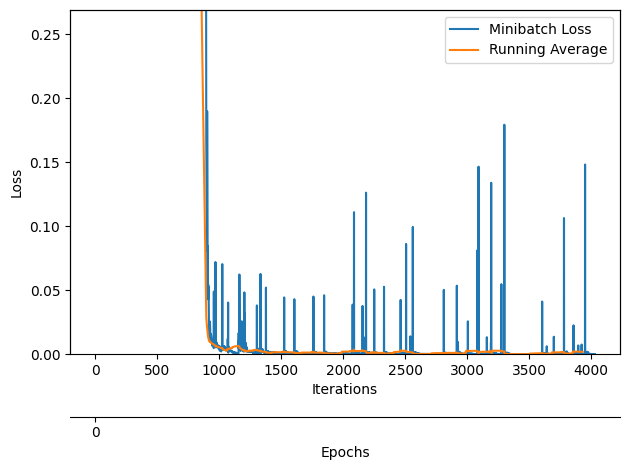

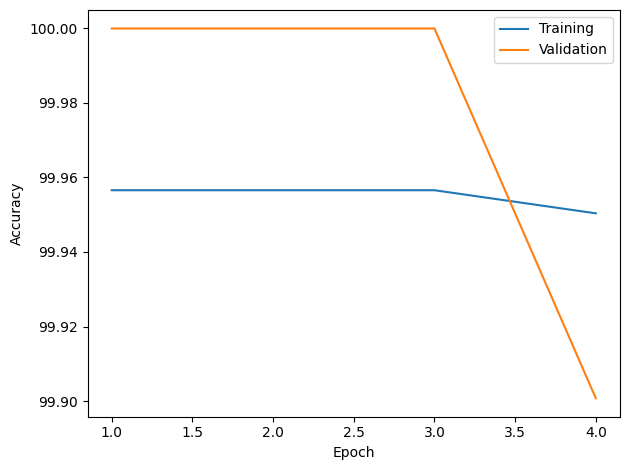

In [15]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.show()

In [114]:
# save model, vocab, and optimizer state
torch.save(model.state_dict(), 'model_data/lstm_01.pt')
torch.save(optimizer.state_dict(), 'model_data/optimizer_01.pt')

# save the vocab
with open('model_data/vocab_01.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [109]:
def get_prediction(model, sentence):

    with torch.no_grad():
        model.eval()
        if type(sentence) == str:
            tokenized = tokenizer(sentence)
        elif type(sentence) == list:
            tokenized = sentence
        else:
            raise TypeError('sentence must be str or list')
        indexed = [vocab[t] for t in tokenized]
        # print(indexed)
        length = [len(indexed)]
        tensor = torch.LongTensor(indexed).to(DEVICE)
        tensor = tensor.unsqueeze(1)
        prediction = F.softmax(model(tensor), dim=1)
    return prediction.to("cpu").squeeze(dim=0).detach().numpy()

In [112]:
# shuffle reports
random.shuffle(reports)

for i in range(10):
    report = reports[i]
    pred = get_prediction(model, report[0])
    print(report[1], np.argmax(pred), pred)

dfs 1 [5.6039954e-07 9.9999940e-01]
bfs 0 [9.9999988e-01 1.2491958e-07]
bfs 0 [9.9999988e-01 1.2491958e-07]
bfs 0 [9.9999988e-01 1.2491958e-07]
bfs 0 [9.999999e-01 1.249098e-07]
dfs 1 [5.6039954e-07 9.9999940e-01]
dfs 1 [5.6039954e-07 9.9999940e-01]
dfs 1 [5.6039954e-07 9.9999940e-01]
bfs 0 [9.9999988e-01 1.2491958e-07]
dfs 1 [5.6039954e-07 9.9999940e-01]
